In [1]:
import logging
from argparse import ArgumentParser

import torch
import torch.nn.functional as F
# import wandb
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm import trange

from experiments.data import INRDataset
from experiments.utils import (
    common_parser,
    count_parameters,
    get_device,
    set_logger,
    set_seed,
    str2bool,
)
from nn.models import DWSModelForClassification, MLPModelForClassification , DWSModel

from experiments.mnist.generate_data_splits import generate_splits
from experiments.mnist.compute_statistics import compute_stats

set_logger()

In [2]:
torch.cuda.empty_cache()

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.enabled = False

In [4]:
# generate_splits(data_path="notebooks/dataset/mnist-inrs", save_path="dataset")

In [5]:
# compute_stats(data_path="notebooks/dataset/mnist_splits.json", save_path="dataset", batch_size=1024)

## INR Dataset

We create INR Datasets and Dataloaders, and visualize some INRs (by reconstruction the images).



In [6]:
#Loading inr data we created while mnist training
import os
current_working_directory = os.getcwd()
print(current_working_directory)
path = current_working_directory + "/notebooks/dataset/mnist_splits.json"
statistics_path = current_working_directory + "/notebooks/dataset/statistics.pth"
normalize = True
augmentation = True

batch_size = 32
num_workers = 1

/work/talisman/sgupta/DWSNets/equivariant-diffusion


/work/talisman/sgupta/DWSNets/equivariant-diffusion/experiments/data.py:315: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location="cpu")


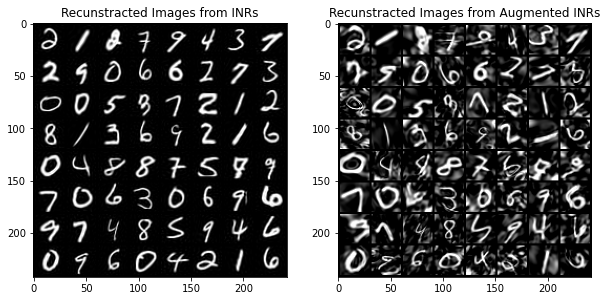

In [7]:
from torchvision.utils import save_image, make_grid
import torch

from experiments.data import INRImageDataset
from experiments.utils import set_seed
import matplotlib.pyplot as plt
dataset = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=False,
    split="train",
)

loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

dataset_aug = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=True,
    split="train",
)
loader_aug = torch.utils.data.DataLoader(dataset_aug, batch_size=64, shuffle=False)

batch = next(iter(loader))
batch_aug = next(iter(loader_aug))

fig, axs = plt.subplots(1, 2, figsize=(10,20)) 

axs[0].imshow(make_grid(batch.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[0].set_title('Recunstracted Images from INRs')

axs[1].imshow(make_grid(batch_aug.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[1].set_title('Recunstracted Images from Augmented INRs')
plt.show()

In [8]:
train_set = INRDataset(
        path=path,
        split="train",
        normalize=normalize,
        augmentation=augmentation,
        statistics_path=statistics_path,
    )

val_set = INRDataset(
    path=path,
    split="val",
    normalize=normalize,
    statistics_path=statistics_path,
)

test_set = INRDataset(
    path=path,
    split="test",
    normalize=normalize,
    statistics_path=statistics_path,
)

train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

logging.info(
    f"train size {len(train_set)}, "
    f"val size {len(val_set)}, "
    f"test size {len(test_set)}"
)

/work/talisman/sgupta/DWSNets/equivariant-diffusion/experiments/data.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.stats = torch.load(statistics_path, map_locati

In [9]:
point = train_set.__getitem__(4)
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)
print(weight_shapes,bias_shapes)
# print(point.weights,point.biases,point.label)

(torch.Size([2, 32]), torch.Size([32, 32]), torch.Size([32, 1])) (torch.Size([32]), torch.Size([32]), torch.Size([1]))


/work/talisman/sgupta/DWSNets/equivariant-diffusion/experiments/data.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=lambda 

In [10]:
new_weight_shapes = (torch.Size([2, 8]), torch.Size([8, 8]), torch.Size([8, 1]))
new_bias_shapes = (torch.Size([8]), torch.Size([8]), torch.Size([1]))

In [11]:
from typing import Tuple
import torch
import torch.nn as nn
from nn.layers import BN, DWSLayer,InvariantLayer, Dropout, ReLU
from nn.layers.base import BaseLayer,GeneralSetLayer

class DWSEncoder(BaseLayer):
    def __init__(
       self,
        weight_shapes,
        bias_shapes,
        input_features,
        hidden_dims,
        downsample_dim,
        n_hidden=2,
        reduction="max",
        bias=True,
        n_fc_layers=1,
        num_heads=4,
        set_layer="sab",
        add_layer_skip=False,
        input_dim_downsample=None,
        dropout_rate=0.0,
        init_scale=1.,
        init_off_diag_scale_penalty=1.,
        bn=False,
        diagonal=False,
    ):
        super().__init__(
            in_features=input_features,
            out_features=hidden_dims,
            bias=bias,
            reduction=reduction,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
        )

        assert len(weight_shapes) > 2, "The implementation only supports networks with more than 2 layers."

        self.downsample_dim = downsample_dim
        self.bias = bias
        self.n_fc_layers = n_fc_layers
        self.num_heads = num_heads
        
        self.skip = self._get_mlp(
            in_features=input_features,
            out_features=input_features,
            bias=bias,
        )
        
        self.InitialLayer = DWSModel(
            weight_shapes= weight_shapes,
            bias_shapes= bias_shapes,
            input_features=input_features,
            hidden_dim=hidden_dims,
            n_hidden=n_hidden,
            reduction=reduction,
            bias=bias,
            output_features=input_features,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
            dropout_rate=dropout_rate,
            input_dim_downsample=input_dim_downsample,
            init_scale=init_scale,
            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
            bn=bn,
            add_skip=False,
            add_layer_skip=add_layer_skip,
            diagonal=diagonal,
        )
        
    def downsample_input_weights(self, inputs, downsample_dim):
        """Downsample the input weights to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first weight dimension [32,2,32,1] -> [32,2,8,1]
        inputs[0] = self._downsample_weight(inputs[0], dim=2, downsample_dim = downsample_dim)
        # Downsample second weight dimension [32,32,32,1] -> [32,8,8,1]
        inputs[1] = self._downsample_weight(inputs[1], dim=1, downsample_dim = downsample_dim)
        inputs[1] = self._downsample_weight(inputs[1], dim=2, downsample_dim = downsample_dim)

        # Downsample third weight dimension [32,32,1,1] -> [32,8,1,1]
        inputs[2] = self._downsample_weight(inputs[2], dim=1, downsample_dim = downsample_dim)

        return tuple(inputs)

    def downsample_input_biases(self, inputs, downsample_dim):
        """Downsample the input biases to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first bias dimension [32,32,1] -> [32,8,1]
        inputs[0] = self._downsample_bias(inputs[0], downsample_dim= downsample_dim)

        # Downsample second bias dimension [32,32,1] -> [32,8,1]
        inputs[1] = self._downsample_bias(inputs[1], downsample_dim = downsample_dim)

        return tuple(inputs)

    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
        """Forward pass through the encoder."""
        x = self.InitialLayer(x)
        weights = self.downsample_input_weights(x[0], 24)
        biases = self.downsample_input_biases(x[1], 24)
        weights = self.downsample_input_weights(weights, 16)
        biases = self.downsample_input_biases(biases, 16)
        weights = self.downsample_input_weights(weights, self.downsample_dim)
        biases = self.downsample_input_biases(biases, self.downsample_dim)
        out = (weights, biases)
        return out

    def _downsample_weight(self, weight, dim,downsample_dim):
        d0 = weight.shape[dim]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features= downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = weight.permute(0, 3, 1, 2) if dim == 2 else weight.permute(0, 3, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 3, 1) if dim == 2 else wi.permute(0, 3, 2, 1)

    def _downsample_bias(self, bias, downsample_dim):
        d0 = bias.shape[1]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features=downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = bias.permute(0, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 1)

In [12]:
import numpy as np
class EncoderMNIST(nn.Module):
    def __init__(self,
            input_features,
            weight_shapes,
            bias_shapes,
            hidden_dims,
            downsample_dim,
            n_hidden=2,
            reduction = "attn",
            input_dim_downsample=None,
            bn = False,
    ):
        super().__init__()
        self.encoder = DWSEncoder(weight_shapes=weight_shapes,
                                bias_shapes=bias_shapes,
                                input_features=input_features,
                                hidden_dims=hidden_dims,
                                downsample_dim = downsample_dim,
                                n_hidden=n_hidden,
                                reduction= reduction,
                                bn=bn).to(device)
        self.dropout = Dropout(0.0)
        self.relu = ReLU()
        self.clf = InvariantLayer(
            weight_shapes=new_weight_shapes,
            bias_shapes=new_bias_shapes,
            in_features=input_features,
            out_features=10,
            reduction=reduction,
            n_fc_layers=2,
        )
        
    def forward(self,inputs):
        encoded_data = self.encoder(inputs)
        output = self.clf(self.dropout(self.relu(encoded_data)))
        return output

Training MNIST

  0%|          | 0/25 [00:00<?, ?it/s]

test accuracy:0.7484


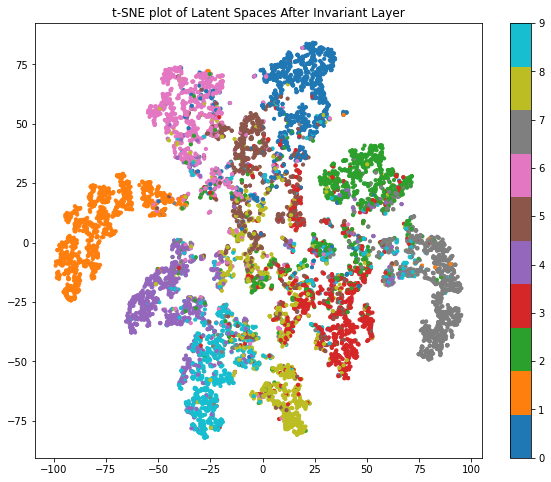

In [14]:
import warnings
warnings.filterwarnings("ignore")

import logging
from tqdm import trange
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss = 0.0
    correct = 0.0
    total = 0.0
    predicted, gt = [], []
    for batch in loader:
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        out = model(inputs)
        loss += F.cross_entropy(out, batch.label, reduction="sum")
        total += len(batch.label)
        pred = out.argmax(1)
        correct += pred.eq(batch.label).sum()
        predicted.extend(pred.cpu().numpy().tolist())
        gt.extend(batch.label.cpu().numpy().tolist())

    model.train()
    avg_loss = loss / total
    avg_acc = correct / total

    return dict(avg_loss=avg_loss, avg_acc=avg_acc, predicted=predicted, gt=gt)

model = EncoderMNIST(
    input_features=1,
    weight_shapes = weight_shapes, 
    bias_shapes = bias_shapes,
    downsample_dim = 32,
    hidden_dims=32,
    reduction = "max",
    n_hidden=8,
    bn=False,
).to(device)
        
model.load_state_dict(torch.load("Outputs/model_encoder.pth"))
epochs = 25
epoch_iter = trange(epochs)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, amsgrad=True, weight_decay=5e-4)


def plot_tsne(model):
    latent_spaces = []
    latent_space_weights = []
    latent_space_biases = []
    labels = []

    for i, batch in enumerate(test_loader):
        model.train()
        optimizer.zero_grad()

        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)

        # Forward pass (assuming the model outputs a tuple with weights and biases)
        out= model(inputs)

        latent_spaces.append(out.cpu().detach().numpy())
        labels.append(batch.label.cpu().numpy())

    # Concatenate latent spaces and labels for t-SNE
    all_latent_weight = np.concatenate(latent_spaces, axis=0)
    all_labels = np.concatenate(labels, axis=0)

    # Apply t-SNE for weights
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000)
    tsne_results_weights = tsne.fit_transform(all_latent_weight)
    # Plot t-SNE for weights
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results_weights[:, 0], tsne_results_weights[:, 1], c=all_labels, cmap='tab10', s=10)
    plt.colorbar(scatter, ticks=np.arange(0, 10))  # Assuming 10 classes
    plt.title(f't-SNE plot of Latent Spaces After Invariant Layer')
    plt.show()

# for epoch in epoch_iter:
#     for i, batch in enumerate(train_loader):
#         model.train()
#         optimizer.zero_grad()

#         batch = batch.to(device)
#         inputs = (batch.weights, batch.biases)
#         out = model(inputs)

#         loss = criterion(out, batch.label)
#         loss.backward()
#         optimizer.step()

#         epoch_iter.set_description(
#             f"[{epoch} {i+1}], train loss: {loss.item():.3f}"
#         )
#     test_loss_dict = evaluate(model, test_loader)
#     test_acc = test_loss_dict['avg_acc'].item()
#     print(f"test accuracy:{test_acc:.4f}")
#     torch.save(model.state_dict(), "Outputs/model_encoder.pth")
        
test_loss_dict = evaluate(model, test_loader)
test_acc = test_loss_dict['avg_acc'].item()
print(f"test accuracy:{test_acc:.4f}")

plot_tsne(model)